# PsyNeuLink: Stroop Model
> Colab tip: Open the left sidebar (☰)  -> **Table of Contents** to navigate this notebook.

## Content

- [0. Setup and Installation](#0-Setup-and-Installation)
- [1. Basics](#1-Basics)

## 0. Setup and Installation

Run this once (or whenever you restart the runtime). This will install PsyNeuLink and import it.

In [3]:
try:
    import psyneulink as pnl
    print("psyneulink already installed")
except ImportError:
    %pip install psyneulink
    import psyneulink as pnl

psyneulink already installed


## 1. Basics

**Content**

- [Mechanisms](#Mechanisms)
- [Compositions](#Compositions)
- [Show Graph](#Show-Graph)

### Mechanisms

Let's create our first composition in PsyNeuLink that consists of only two mechanisms: `Input` and `Output`. We will give both of them `2` input- and output-ports. For the `Input` we leave `Linear` (the default value) as function, for the `Output`, we will assign a Logistic function. Following machine learning conventions, we will use the term `layer` to refer to these mechanisms.



In [21]:
input_layer = pnl.ProcessingMechanism(name="Input", input_shapes=2)
output_layer = pnl.ProcessingMechanism(name="Output", input_shapes=2, function=pnl.Logistic)

### Compositions

We can now combine these two layers into a `Compositions` object. First, we will define a `pathway` via a list. When we give this pathway to PsyNeuLink it will automatically create a `MappingProjection` between the two layers with reasonable default parameters. In this case, it will create a identity matrix (2x2) wiring the output-port of the `input_layer` to the input-port of the `output_layer`.

In [22]:
in_out_pathway = [input_layer, output_layer]
simple_comp = pnl.Composition(name="simple_comp", pathways=[in_out_pathway]) # Note: pathways expects a list of lists (or pathways

We can execute mechanisms individually by passing an array of the appropriate size:

In [23]:
input_layer.execute([0, 1])

array([[0., 1.]])

We can also execute the entire composition by passing an array to the `run` method:

In [24]:
simple_comp.run([0, 1])

array([[0.5       , 0.73105858]])

or with a list of inputs. The results are stored in the `results` attribute of the compositions.

In [25]:
simple_comp.run([[0, 1], [1, 0], [0.5, 0.5]])
simple_comp.results # Note this also shows the results of the previous run (when running this multiple times the results will be appended)

array([[[0.5       , 0.73105858]],

       [[0.5       , 0.73105858]],

       [[0.73105858, 0.5       ]],

       [[0.62245933, 0.62245933]]])

### Show Graph

A very handy feature of PsyNeuLink is the ability to visualize the composition as a graph:

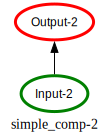

In [26]:
simple_comp.show_graph(output_fmt='jupyter')

The show graph function has many options to customize the output. For example, we can show a more detailed view of the nodes by setting `show_node_structure=True`:

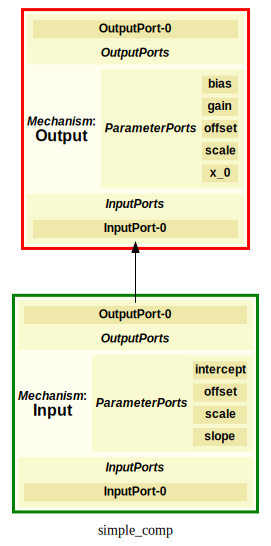

In [16]:
simple_comp.show_graph(output_fmt='jupyter', show_node_structure=True)

### Projections

So far we have only implicitly created a `MappingProjection` by passing a list of mechanisms as a `pathway`. However, if we want more control over the projection, we can create it explicitly. To do so, we define a weight matrix and pass it to the `MappingProjection` constructor. The weight matrix needs to have a shape that is compatible with the output-port of the sender mechanism and the input-port of the receiver mechanism. In this case, both layers have 2 input- and output-ports, so we can use a 2x2 matrix (To make it easier to see, we will use input and output layers with linear identity functions):


In [33]:
input_layer = pnl.ProcessingMechanism(name="Input", input_shapes=2)
output_layer = pnl.ProcessingMechanism(name="Output", input_shapes=2)

# matrix is defined as a list of matrix columns
matrix = [[1, 2],  # weights from input_layer[0] to output_layer[0, 1]
          [3, 4]]  # weights from input_layer[1] to output_layer[0, 1]

projection = pnl.MappingProjection(matrix=matrix)

# Here we show another way of adding a pathway after the composition has been created
simple_comp = pnl.Composition(name="simple_comp")
simple_comp.add_linear_processing_pathway([input_layer, projection, output_layer])

Again, we can run the composition

In [34]:
simple_comp.run([0, 1])

array([[3., 4.]])

In this case, the output can be understood as matrix multiplication between

$$
\begin{bmatrix}
1 & 3 \\
2 & 4
\end{bmatrix}
\cdot
\begin{bmatrix}
0 \\
1
\end{bmatrix}
=
\begin{bmatrix}
3 \\
4
\end{bmatrix}
$$



<details>
<summary>
What is the output of the composition if we run it with input `[1, 1]`?
</summary>
$$
\begin{bmatrix}
1 & 3 \\
2 & 4
\end{bmatrix}
\cdot
\begin{bmatrix}
1 \\
1
\end{bmatrix}
=
\begin{bmatrix}
4 \\
6
\end{bmatrix}
$$
</details>

In [35]:
simple_comp.run([1, 1])

array([[4., 6.]])